In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as dset
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

In [63]:
#Loading the model vgg19 that will serve as the base model
model=models.vgg19(pretrained=True).features
#Assigning the GPU to the variable device
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


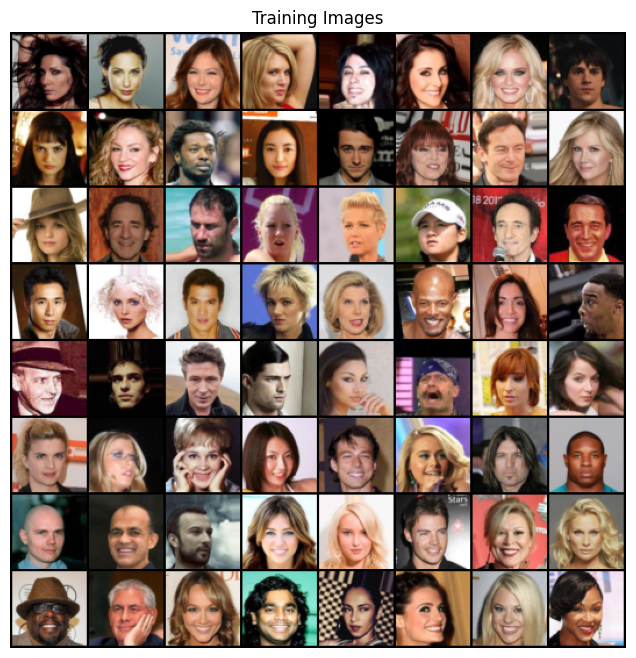

In [ ]:
dataroot = "/content/gdrive/MyDrive/celebA"
workers = 2
batch_size = 128
image_size = 64
ngpu = 1

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [65]:
#defing a function that will load the image and perform the required preprocessing and put it on the GPU
def image_loader(path):
    image=Image.open(path)
    #defining the image transformation steps to be performed before feeding them to the model
    loader=transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
    #The preprocessing steps involves resizing the image and then converting it to a tensor
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

#Loading the original and the style image
original_image=image_loader('/content/gdrive/MyDrive/Nikola-Tesla.jpg')
style_image=image_loader('/content/gdrive/MyDrive/malnyun/image/1.jpg')

#Creating the generated image from the original image
# generated_image=original_image.clone().requires_grad_(True)
generated_image=original_image

In [66]:
#Defining a class that for the model
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28'] 
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features

In [67]:
def calc_content_loss(gen_feat,orig_feat):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)
    return content_l

In [68]:
def calc_style_loss(gen,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calcultating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2)
    return style_l

In [69]:
def calculate_loss(gen_features, orig_feautes, style_featues):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_feautes,style_featues):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)
    
    #calculating the total loss of e th epoch
    total_loss=alpha*content_loss + beta*style_loss 
    return total_loss

In [70]:
#Load the model to the GPU
model=VGG().to(device).eval() 

#initialize the paramerters required for fitting the model
# epoch=7000
epoch = 100
lr=0.004
alpha=8
beta=70

#using adam optimizer and it will update the generated image not the model parameter 
optimizer=optim.Adam([generated_image],lr=lr)

tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1566e+10, device='cuda:0', grad

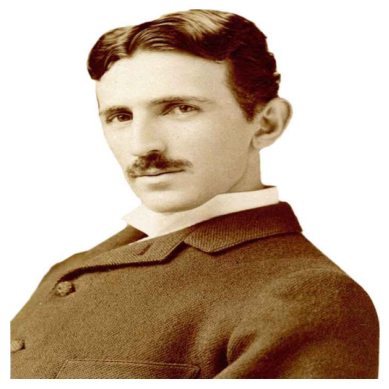

In [71]:

#iterating for 1000 times
for e in range (epoch):
    #extracting the features of generated, content and the original required for calculating the loss
    gen_features=model(generated_image)
    orig_feautes=model(original_image)
    style_featues=model(style_image)
    
    #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
    total_loss=calculate_loss(gen_features, orig_feautes, style_featues)
    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    #print the image and save it after each 100 epoch
    if(e/100):
        print(total_loss)
        
        save_image(generated_image,"gen.png")
image = Image.open("gen.png")
# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: turn off axes
plt.show()

Epoch: 0, Total Loss: 109907.375
Epoch: 100, Total Loss: 6.424526214599609
Epoch: 200, Total Loss: 1.359513282775879
Epoch: 300, Total Loss: 0.3160276412963867
Epoch: 400, Total Loss: 0.31737932562828064


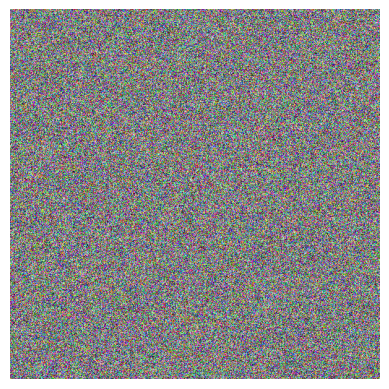

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torchvision.utils import save_image
# import torch.optim as optim
# import torch.nn as nn
# import torchvision.models as models
# import matplotlib.pyplot as plt

# n=0
# # Set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define the transformation for the images
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),
#     transforms.ToTensor()
# ])

# # Load the original images from a folder
# original_dataset = ImageFolder(root="/content/gdrive/MyDrive/celebA", transform=transform)
# original_dataloader = torch.utils.data.DataLoader(original_dataset, batch_size=1, shuffle=False)

# # Load the style images from a folder
# style_dataset = ImageFolder(root="/content/gdrive/MyDrive/malnyun", transform=transform)
# style_dataloader = torch.utils.data.DataLoader(style_dataset, batch_size=1, shuffle=False)

# # Load the VGG model
# model = models.vgg19(pretrained=True).features.to(device).eval()

# # Define the generated image
# generated_image = torch.randn((1, 3, 512, 512)).to(device).requires_grad_(True)

# # Define the loss function
# loss_fn = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam([generated_image], lr=0.01)

# # Iterate over the original and style images
# for orig_img, style_img in zip(original_dataloader, style_dataloader):
#     orig_img = orig_img[0].to(device)
#     style_img = style_img[0].to(device)
    
#     # Reset the generated image
#     generated_image.data = torch.randn((1, 3, 512, 512)).to(device).requires_grad_(True)
    
#     # Training loop
#     for epoch in range(500):
#         # Forward pass
#         gen_features = model(generated_image)
#         orig_features = model(orig_img)
#         style_features = model(style_img)
        
#         # Calculate the content loss
#         content_loss = loss_fn(gen_features[-1], orig_features[-1])
        
#         # Calculate the style loss
#         style_loss = 0
#         for gen_feat, style_feat in zip(gen_features, style_features):
#             gen_gram = torch.mm(gen_feat.view(gen_feat.size(1), -1), gen_feat.view(gen_feat.size(1), -1).t())
#             style_gram = torch.mm(style_feat.view(style_feat.size(1), -1), style_feat.view(style_feat.size(1), -1).t())
#             style_loss += loss_fn(gen_gram, style_gram)
        
#         # Total loss
#         total_loss = content_loss + style_loss
        
#       # Backward pass/
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
#         # Print the loss
#         if epoch % 100 == 0:
#             print(f"Epoch: {epoch}, Total Loss: {total_loss.item()}")
    
#     # Save the generated image
#     n=n+1
#     save_image(generated_image, f"generated_image_{n}.png")

# # Display the generated image
# generated_image = generated_image.detach().cpu()
# plt.imshow(transforms.ToPILImage()(generated_image.squeeze()))
# plt.axis('off')
# plt.show()
